In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "drive/MyDrive/ColabNotebooks/optimal_portfolios"

/content/drive/MyDrive/ColabNotebooks/optimal_portfolios


In [3]:
!pip install yfinance
!pip install wrds
!pip install keras --upgrade
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [4]:
pip install dask

In [5]:
pip install dask[dataframe]

# Imports

In [6]:
from data_querier import DataQuerierYF
from config import load_config
from portfolios.equally_weighted import EquallyWeighted
from portfolios.market_weights import MarketWeighted
import matplotlib.pyplot as plt 
from portfolios.reinforcement_learning.DQN.agent import AgentDQN
from portfolios.reinforcement_learning.DQN.environment import MarketEnviormentTorch
from portfolios.reinforcement_learning.ActorCritic.agent import AgentActorCritic, BaselineMethod
from portfolios.reinforcement_learning.ActorCritic.environment import MarketEnviormentKeras
from utils import DataModes
from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output

from matplotlib.animation import FuncAnimation
import numpy as np
import tensorflow as tf
from tqdm import tqdm

configuration = load_config()
seed = 13041999
np.random.seed(seed)
tf.random.set_seed(seed*2)

# Data Download

In [ ]:
data_getter = DataQuerierYF(configuration)

# Equally weighted

In [ ]:
portfolio = EquallyWeighted(configuration)
portfolio.data

In [ ]:
equal = portfolio()
equal.plot(grid=True, ylabel="Cumulative returns", xlabel="time", title="Cumulative returns of the equally weighted portfolio on the SP500 companies", figsize=(15, 10)) 

# Market weights

In [ ]:
portfolio = MarketWeighted(configuration)

In [ ]:
market = portfolio()
market.plot(grid=True, ylabel="Cumulative returns", xlabel="time", title="Cumulative returns of the market weighted portfolio on the SP500 companies", figsize=(15, 10))

In [ ]:
plt.plot(equal, label="equal weights")
plt.plot(market, label="market weights")
plt.xlabel("time")
plt.ylabel("Cumulative returns")
plt.title("Cumulative returns of portfolios on the SP500 companies")
plt.grid()
plt.legend()
plt.rcParams["figure.figsize"] = (15, 10)


# Reinforcement Learning

## DQN

In [ ]:
market_env = MarketEnviorment(configuration, DataModes.TRAINING)
agent = Agent(configuration, market_env, 256, 64)

In [ ]:
agent.train()

## Actor Critic

In [7]:
class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Log return')
        plt.title("log returns per episode")
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

In [8]:
num_episodes = 5000

def run_experiment(experiment_name, 
                   env, 
                   num_episodes, 
                   policy_learning_rate=0.001, 
                   value_learning_rate=0.001, 
                   baseline=None, 
                   entropy_cost=0, 
                   max_ent_cost=0, 
                   num_layers=3):

    
    agent = AgentActorCritic(n_obs=env.state_dim, 
                    action_space=env.action_dim,
                    policy_learning_rate=policy_learning_rate, 
                    value_learning_rate=value_learning_rate, 
                    discount=0.99, 
                    baseline=baseline, 
                    entropy_cost=entropy_cost, 
                    max_ent_cost=max_ent_cost,
                    num_layers=num_layers)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in tqdm(range(1, num_episodes+1)):
    
        
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards).flatten()
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        
        
        episode_reward = 0

        for t, observation in env.__iter__():
        
            #if episode_frames is not None:
            #    episode_frames.append(env.render(mode='rgb_array'))

            
            action = agent.decide(observation)

            
            next_observation, reward, done = env.step(t, action)
            episode_reward += reward

            
            agent.observe(observation, action, reward)


            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            
            #observation = next_observation
            step += 1
            
    return all_episode_frames, agent

In [9]:
env = MarketEnviormentKeras(DataModes.TRAINING, configuration)

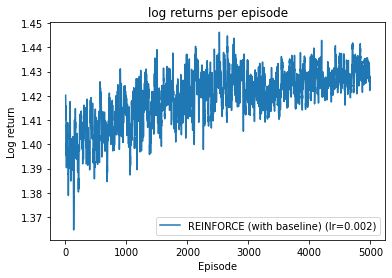

100%|██████████| 5000/5000 [4:18:09<00:00,  3.10s/it]


In [10]:
results = Results()
policy_learning_rate = 0.002
_, agent = run_experiment("REINFORCE (with baseline) (lr=" + str(policy_learning_rate) +")", env, num_episodes, policy_learning_rate, 
                             baseline=BaselineMethod.ADAPTIVE)

#save the results 
results.save('REINFORCE_adaptive_baseline.npz')

In [11]:

agent.policy_network.save("model_policy_2")
agent.value_network.save("model_value_2")
with open('agent.pickle', 'wb') as handle:
    pickle.dump(agent, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: model_policy_2/assets


INFO:tensorflow:Assets written to: model_policy_2/assets


INFO:tensorflow:Assets written to: model_value_2/assets


INFO:tensorflow:Assets written to: model_value_2/assets


INFO:tensorflow:Assets written to: ram://1215da37-26d9-4cef-a7c8-61410796b839/assets


INFO:tensorflow:Assets written to: ram://1215da37-26d9-4cef-a7c8-61410796b839/assets


INFO:tensorflow:Assets written to: ram://5ae25050-c445-4c1f-b547-029b7fc5d66c/assets


INFO:tensorflow:Assets written to: ram://5ae25050-c445-4c1f-b547-029b7fc5d66c/assets


In [17]:
import pickle
with open('agent.pickle', 'rb') as handle:
    agent = pickle.load(handle)


agent.policy_network = tf.keras.models.load_model("model_policy_2")
agent.value_network = tf.keras.models.load_model("model_value_2")

In [18]:
x  = np.random.rand(1, env.state_dim)
agent.policy_network(x)

<tf.Tensor: shape=(1, 498), dtype=float32, numpy=
array([[1.89617136e-03, 6.89741632e-04, 6.04467327e-03, 3.83210892e-04,
        2.79700826e-03, 5.50894300e-04, 8.52142926e-04, 4.42071410e-04,
        1.04488412e-04, 4.41182521e-04, 7.10808556e-04, 5.54906670e-04,
        3.33785824e-03, 5.62044559e-04, 1.36188488e-03, 7.13979069e-04,
        3.58383334e-03, 4.38683986e-04, 3.11078713e-03, 1.25330384e-03,
        3.14428442e-04, 5.42293908e-03, 8.25395517e-04, 1.63740217e-04,
        4.29529202e-04, 9.45412728e-04, 4.04113700e-04, 4.69304796e-04,
        4.58403229e-04, 4.59544873e-03, 2.94319564e-03, 5.86158084e-03,
        4.69761639e-04, 5.86887170e-03, 9.30552930e-03, 4.13910602e-04,
        1.15847785e-03, 2.13301345e-03, 1.87731493e-04, 4.52115753e-04,
        1.20456493e-03, 1.85348676e-03, 3.53312003e-04, 1.29286048e-03,
        1.71927072e-03, 7.12176971e-03, 3.32046836e-03, 1.70329789e-04,
        1.05810142e-03, 1.42929261e-03, 5.60283195e-04, 7.17360107e-03,
        4.9641

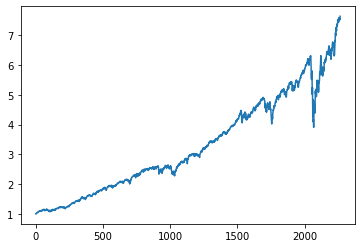

In [31]:
import matplotlib.pyplot as plt
from itertools import chain
test_ENV = MarketEnviormentKeras(DataModes.TESTING, configuration)
train_ENV =  MarketEnviormentKeras(DataModes.TRAINING, configuration)


test = []
actions = []

for t, state in chain(train_ENV.__iter__(), test_ENV.__iter__()):
  action = agent.policy_network([x])
  actions.append(action)
  test.append((action @ state[..., np.newaxis]))

plt.plot(np.array(test).flatten().cumprod())


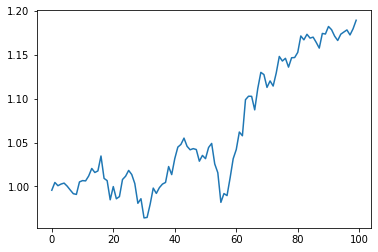

In [32]:
test = []
actions = []

for t, state in test_ENV.__iter__():
  action = agent.policy_network([x])
  actions.append(action)
  test.append((action @ state[..., np.newaxis]))

plt.plot(np.array(test).flatten().cumprod())
